In [1]:
import tensorflow as tf
from tensorflow import keras
# GPUs config
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus) # Looks like we have one GPU, nice!
# Config for GPU memory growth if needed
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
plt.axis("off") # Not shown in the book
plt.show()

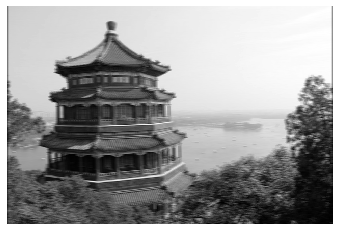

In [3]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

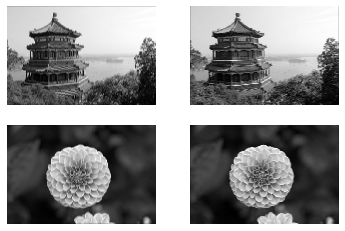

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

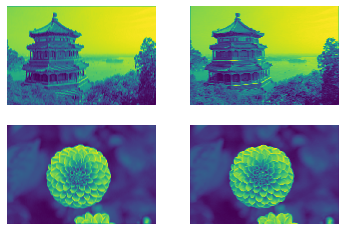

In [6]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_color_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [7]:
def crop(images):
    return images[150:220, 130:250]

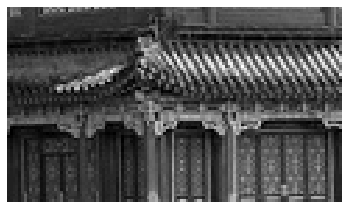

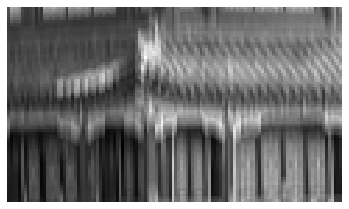

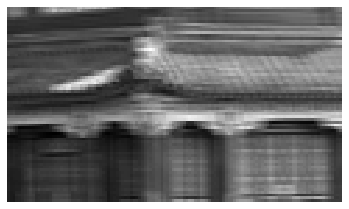

In [8]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

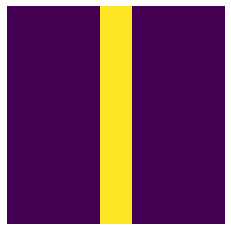

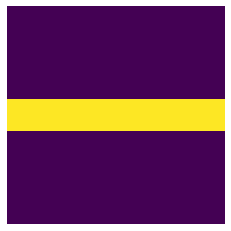

In [9]:
filters[:, 3, :, 0] = 0.5  # vertical line
filters[3, :, :, 1] = 0.9  # horizontal line

plot_color_image(filters[:, :, 0, 0])
plt.show()
plot_color_image(filters[:, :, 0, 1])
plt.show()

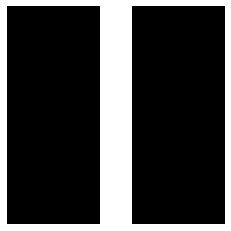

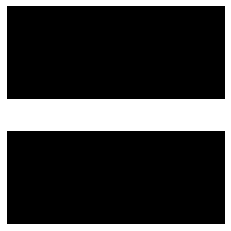

In [10]:
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [11]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, # 32 3x3 filters/kernels
                           padding="SAME", activation="relu")

In [12]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [13]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

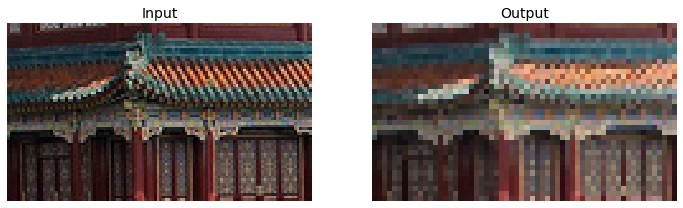

In [14]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [15]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")) # (_,_,_,arg) has to be a multiple of channels
depth_output = depth_pool(cropped_images)
depth_output.shape # Note channels in (batch_size, height, width, channels) got reduced from 3 to 1 because of the "3"

TensorShape([2, 70, 120, 1])

In [16]:
cropped_images.shape

(2, 70, 120, 3)

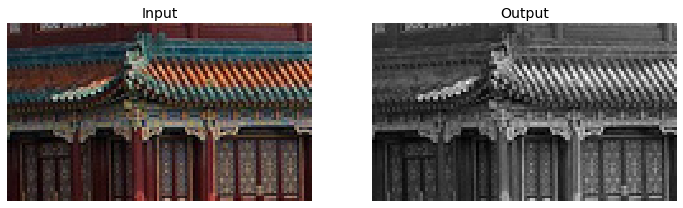

In [17]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

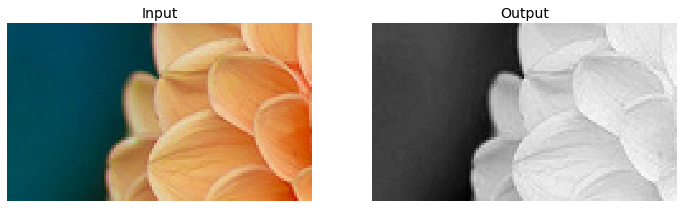

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[1])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[1, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

In [19]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [20]:
output_avg = avg_pool(cropped_images)

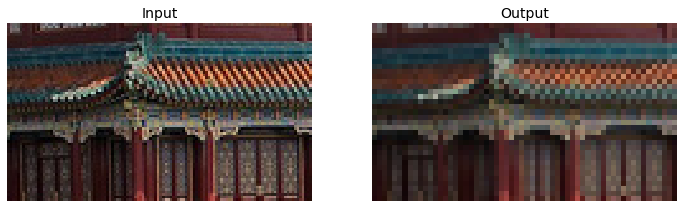

In [21]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [22]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images).shape # One number for each channel

TensorShape([2, 3])

In [23]:
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

In [24]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

In [25]:
(x_train_full, Y_train_full), (x_test, Y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [26]:
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
Y_train, Y_valid = Y_train_full[:-5000], Y_train_full[-5000:]

In [27]:
print(x_train.shape)
print(x_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

(55000, 28, 28)
(5000, 28, 28)
(55000,)
(5000,)


In [28]:
x_train = x_train[..., np.newaxis]
x_valid = x_valid[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [29]:
X_mean = x_train.mean(axis=0, keepdims=True)
X_std = x_train.std(axis=0, keepdims=True) + 1e-7
x_train = (x_train - X_mean) / X_std
x_valid = (x_valid - X_mean) / X_std
x_test = (x_test - X_mean) / X_std

In [31]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [32]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(55000, 28, 28, 1)
(5000, 28, 28, 1)
(55000,)
(5000,)


In [33]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

In [34]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [35]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 198s 115ms/step - loss: 0.6764 - accuracy: 0.7689 - val_loss: 0.3647 - val_accuracy: 0.8652
Epoch 2/10
1719/1719 [==============================] - 201s 117ms/step - loss: 0.4115 - accuracy: 0.8613 - val_loss: 0.3273 - val_accuracy: 0.8836
Epoch 3/10
1719/1719 [==============================] - 284s 165ms/step - loss: 0.3579 - accuracy: 0.8795 - val_loss: 0.2927 - val_accuracy: 0.8876
Epoch 4/10
1719/1719 [==============================] - 292s 170ms/step - loss: 0.3225 - accuracy: 0.8891 - val_loss: 0.2832 - val_accuracy: 0.8954
Epoch 5/10
1719/1719 [==============================] - 291s 169ms/step - loss: 0.3073 - accuracy: 0.8955 - val_loss: 0.2770 - val_accuracy: 0.9022
Epoch 6/10
1719/1719 [==============================] - 295s 172ms/step - loss: 0.2903 - accuracy: 0.9009 - val_loss: 0.2846 - val_accuracy: 0.9010
Epoch 7/10
1719/1719 [==============================] - 296s 172ms/step - loss: 0.2784 - accuracy: 0.9068 - val_

In [36]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [37]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

In [39]:
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    print(filters)

64
64
64
128
128
128
128
256
256
256
256
256
256
512
512
512


In [40]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 10s 0us/step


In [41]:
images[0].shape

(427, 640, 3)

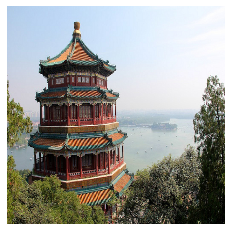

In [42]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


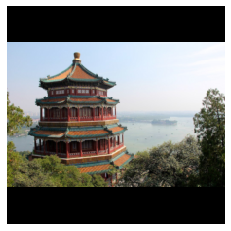

In [43]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

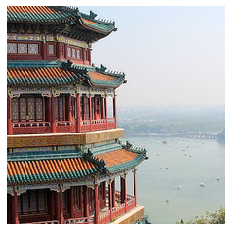

In [44]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224) # If width or height is greater than the specified target_width or target_height respectively, this op centrally crops along that dimension
plot_color_image(images_resized[0])
plt.show()

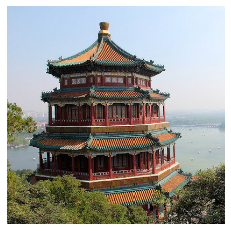

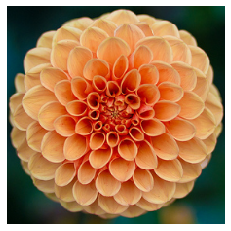

In [45]:
china_box = [0, 0.03, 1, 0.68] # [y1, x1, y2, x2]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224]) # Crop using boxes and resize to [224,224]
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [46]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [47]:
Y_proba.shape # VGG-16 has 1000 classes

(2, 1000)

In [48]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 1us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



In [49]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to C:\Users\taij\tensorflow_datasets\tf_flowers\3.0.0. Subsequent calls will reuse this data.


In [50]:
info.splits # There is only a train dataset, no test no valid

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [51]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [52]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [53]:
n_classes = info.features["label"].num_classes

In [54]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [55]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

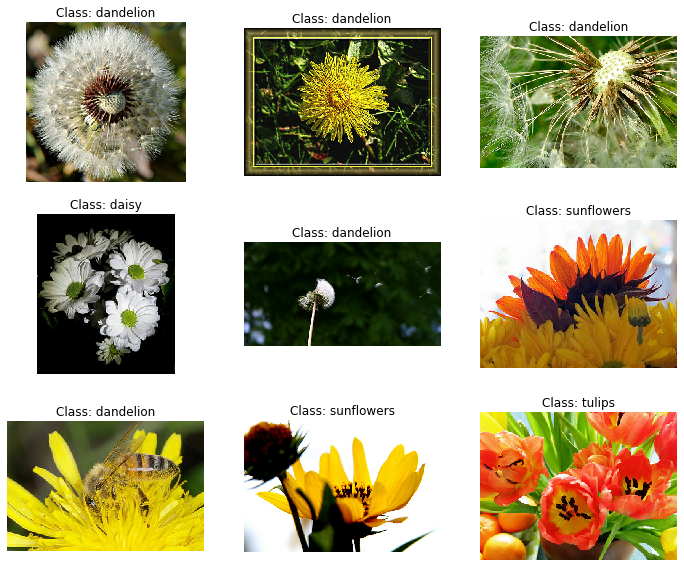

In [56]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [57]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [58]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

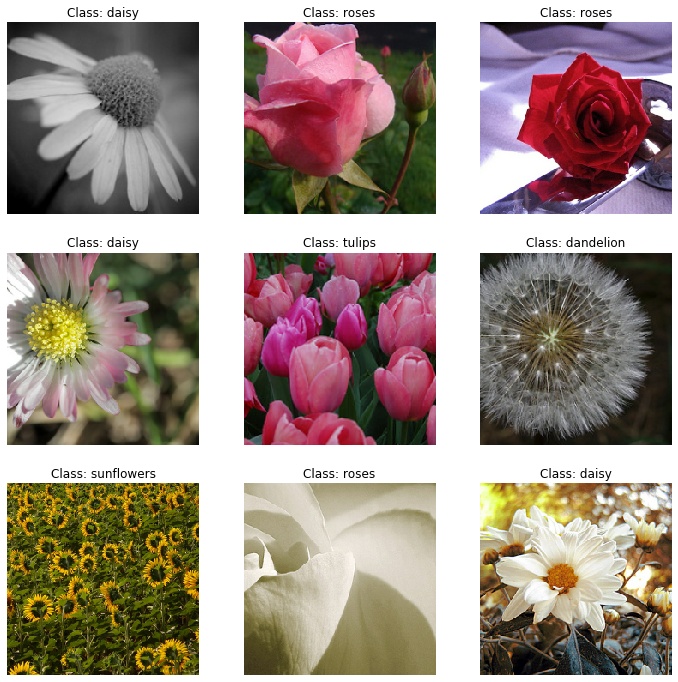

In [59]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

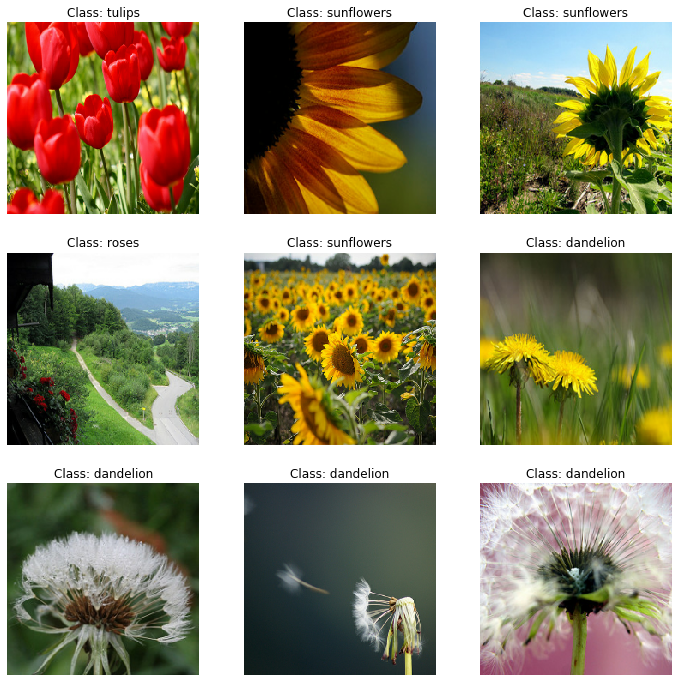

In [60]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [61]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 9s 0us/step


In [62]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_42
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_43
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_44
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [63]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 275s 3s/step - loss: 1.3061 - accuracy: 0.7961 - val_loss: 1.2398 - val_accuracy: 0.8511
Epoch 2/5
86/86 [==============================] - 275s 3s/step - loss: 0.5907 - accuracy: 0.8939 - val_loss: 1.0601 - val_accuracy: 0.8529
Epoch 3/5
86/86 [==============================] - 272s 3s/step - loss: 0.3756 - accuracy: 0.9222 - val_loss: 0.8824 - val_accuracy: 0.8787
Epoch 4/5
86/86 [==============================] - 274s 3s/step - loss: 0.2558 - accuracy: 0.9353 - val_loss: 0.8292 - val_accuracy: 0.8493
Epoch 5/5
86/86 [==============================] - 283s 3s/step - loss: 0.2048 - accuracy: 0.9440 - val_loss: 0.6808 - val_accuracy: 0.8897


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 1298s 15s/step - loss: 0.3504 - accuracy: 0.8819 - val_loss: 0.7587 - val_accuracy: 0.8199
Epoch 2/40
86/86 [==============================] - 1129s 13s/step - loss: 0.1082 - accuracy: 0.9648 - val_loss: 0.4184 - val_accuracy: 0.8934
Epoch 3/40
86/86 [==============================] - 1168s 14s/step - loss: 0.0712 - accuracy: 0.9771 - val_loss: 0.3295 - val_accuracy: 0.9173
Epoch 4/40
86/86 [==============================] - 1083s 13s/step - loss: 0.0401 - accuracy: 0.9862 - val_loss: 0.3121 - val_accuracy: 0.9099
Epoch 5/40
86/86 [==============================] - 1043s 12s/step - loss: 0.0325 - accuracy: 0.9876 - val_loss: 0.2756 - val_accuracy: 0.9154
Epoch 6/40
86/86 [==============================] - 1044s 12s/step - loss: 0.0250 - accuracy: 0.9924 - val_loss: 0.2994 - val_accuracy: 0.9136
Epoch 7/40
86/86 [==============================] - 1045s 12s/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.4211 - val_accuracy: 0.8897